In [2]:
import librosa 
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd


# SeCoT 2019: Computação Musical e Aprendizado de Máquina

---
O processo de representar numericamente o som é chamado de 
**digitalização**. Essa representação depende diretamente de como a 
pressão do ar varia no momento da gravação.

Não vamos entrar em detalhes aqui, mas o computador precisa converter
o sinal analógico em zeros e uns para sua gravação e, da mesma forma,
converter os zeros e uns de volta para os dados analógicos na hora de 
sua reprodução.

A amostragem é feita em função do tempo, observando N pontos da 
amplitude da onda gravada. Após o processo de amostragem digital, a
onda pode ser representada como uma sequência de pontos flutuantes,
como veremos abaixo.

--- 
## Parte 1: Diferentes representações da música e suas interpretações gerais

### 1.0 -- Carregando um áudio

Vamos primeiro carregar um áudio por meio da biblioteca `librosa` e 
descrever algumas de suas informações

In [3]:
# carregando os pontos do sinal e sua frequência de amostragem
x, fs = librosa.core.load(librosa.util.example_audio_file(), sr=None)

print(f'Quantidade de pontos no vetor: {x.size} floats')
print(f'Frequência de amostragem na qual a faixa foi gravada: {fs} Hz')
print(f'Tempo de duração da faixa: {x.size/fs} segundos')
print(f'Alguns exemplos de como o áudio é carregado pelo librosa {x[3000:3010]}')


# plt.plot(x[3000:4000])
ipd.Audio(x, rate=fs)

Quantidade de pontos no vetor: 2710336 floats
Frequência de amostragem na qual a faixa foi gravada: 44100 Hz
Tempo de duração da faixa: 61.45886621315193 segundos
Alguns exemplos de como o áudio é carregado pelo librosa [-0.04494361 -0.0440354  -0.04311257 -0.04216551 -0.04120165 -0.04034019
 -0.03951412 -0.03883646 -0.03813233 -0.03729087]


### 1.1 -- Formas de onda

- É um tipo de representação mais básico e que não tem muita informação aparente
- É a forma de um sinal que se move como uma onda em um meio físico
- Varia em função do tempo
- Informação legal: a forma de onda de um som pode afetar o seu timbre. Sintetizadores
geram sons com formas mais diferentonas

Exemplos de formas de onda periódicas:

![diferentes formas de onda](imgs/ondas.png)

imagem retirada da [Wikipedia](https://en.m.wikipedia.org/wiki/Waveform)

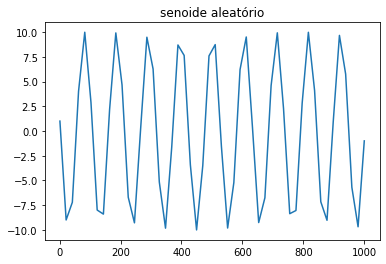

In [4]:
# se tiver curiosidade, muda esses parâmetros e vê como a onda abaixo muda (:
amplitude = 10
comprimento_onda = 2
fase = 0.2

# seno a*sen(2*pi*tempo-fase/comprimento de onda)
seno_x = np.linspace(1, 1000)
seno_y = amplitude * np.sin((2*np.pi*seno_x-fase)/comprimento_onda)

plt.title("senoide aleatório")
plt.plot(seno_x,seno_y)

Voltando para o nosso áudio...

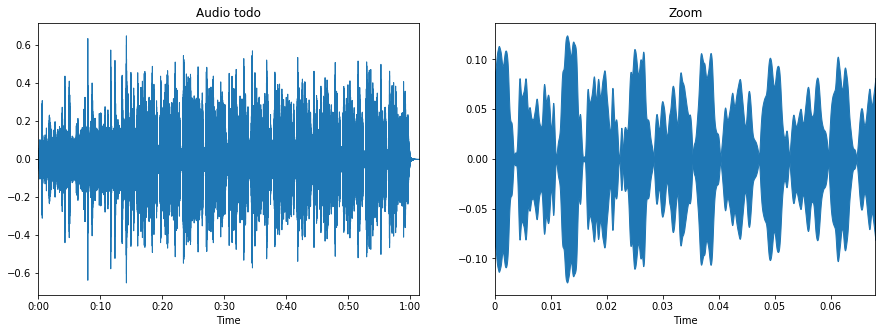

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Audio todo")
librosa.display.waveplot(x, sr=fs)
plt.subplot(1,2,2)
plt.title("Zoom")
librosa.display.waveplot(x[5000:8000], sr=fs)

### 1.2 -- Espectrogramas

- representações do áudio no domínio da frequência
- trazem informações mais úteis sobre o que está acontecendo na música, mas descarta
toda a informação de fase 


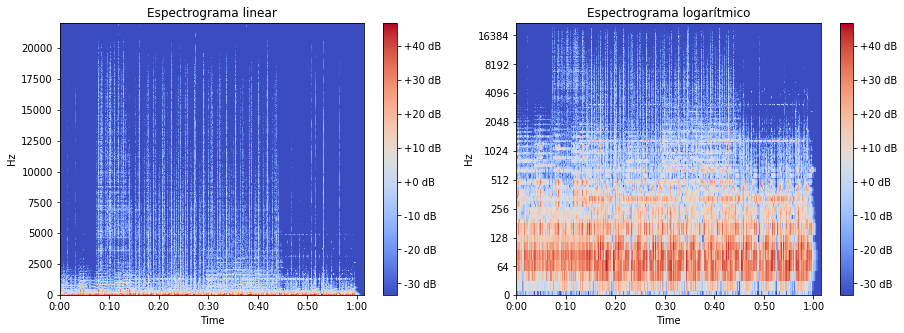

In [10]:
# antes de plotar o espectrograma em si, temos que mudar o domínio do nosso vetor
# para isso, usamos a transformada de Fourier

# mudamos o domínio para o da frequência
X = np.abs(librosa.core.stft(x))

# descomente a linha abaixo se quiser ver como funciona a representaçao no domínio
# da frequência
# SPOILER: não tem muito o que entender logo de cara
# print(X)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Espectrograma linear")
librosa.display.specshow(librosa.amplitude_to_db(X), sr=fs, x_axis="time", y_axis="linear")
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
plt.title("Espectrograma logarítmico")
librosa.display.specshow(librosa.amplitude_to_db(X), sr=fs, x_axis="time", y_axis="log")
plt.colorbar(format='%+2.0f dB')


### 1.3 -- Outras representações

Além do espectrograma e do áudio puro (raw), existem outras representações que são muito usadas.
* STFT (Short Term Fourier Transform)
* MFCC (Mel-Frequency Cepstrum Coeficients)
* Cromagrama
* Tempograma
* Constante-Q
* etc

O uso da entrada depende tanto do sistema que você está desenvolvendo. Todos têm suas vantagens e
desvantagens. Por exemplo, o áudio puro tem muito mais informações que podem ser aproveitadas do que
um espectrograma, contudo seu processamento requer mais poder computacional. Da mesma forma, o 
espectrograma tem uma repesentação mais compacta do áudio e, mesmo assim, pode ter atributos que
são relevantes para a grande maioria das tarefas. Por isso até é uma das representações mais usadas.

Informação interessante: existem algumas representações que buscam simular a maneira que ouvimos e, para isso,
usam escala logarítmica, já que a maneira que ouvimos as frequências segue ela. 
Exemplos de escala são: escala Mel, escala Bark e ERB. 

---
## Parte 2: Identificando elementos do áudio

Agora que a gente já conhece algumas das representações, vamos ver o tipo de informação
e características que conseguimos extrair do áudio e como fazer isso.

Lembrando que não é muito útil a gente ter essas características em relação ao áudio todo
porque isso não consegue captar o que acontece localmente. É mais interessante dividirmos 
o sinal em frames e daí extrair as características.

### 2.1 -- Energia (Energy)
A energia é a magnitude total de um sinal. No caso de sinais de áudio, correspondem ao quão 
"alto" um sinal é.

$$ 
    \sum_n \left| x(n) \right|^2 
$$

In [12]:
# o tamanho do frame é completamente arbritário
energia = np.array([])
frame_size = 1024
# o hop size é o tamanho do pulo que vamos dar entre os cálculos
# ele geralmente é menor que o frame_size pra gente
hop_size = 512  

# energia total do áudio
energia_total = np.sum(np.abs(x)**2)
print(f'Energia total: {energia_total}') # ... não adianta muita coisa pra gente, né?

for i in range(0, x.size, hop_size):
    energia = np.append(energia, np.sum(np.abs(x[i:i+frame_size])**2))

Energia total: 31691.619140625


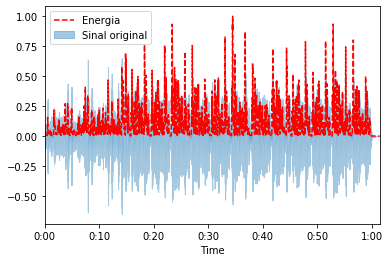

In [13]:
# vamos ver como essa energia caputada por frame se comporta
frames = range(len(energia))
t = librosa.frames_to_time(frames, sr=fs, hop_length=hop_size)

librosa.display.waveplot(x, sr=fs, alpha=0.4)
plt.plot(t, energia/energia.max(), 'r--')             
plt.legend(('Energia', 'Sinal original'))

#plt.plot(energia)

   
### 2.2 -- Taxa de Cruzamento por Zero (Zero Crossing Rate)
A [taxa de cruzamento por zero](https://en.wikipedia.org/wiki/Zero-crossing_rate) indica 
quantas vezes o sinal cruzou o eixo horizontal, ou seja, qual a taxa de variação desse sinal.

$$ zcr = \frac{1}{T-1} \sum_{t=1}^{T-1} \mathbb{1}_{ \mathbb{R}_{< 0} } (s_t s_{t-1})$$

In [ ]:
# eu tô com preguiça de fazer na mão, vamos usar direto a função do librosa
zcrs = librosa.feature.zero_crossing_rate(x)


#librosa.display.waveplot(x, sr=fs, alpha=0.4)
plt.plot(zcrs[0], 'r--')
#plt.plot(t, energia/energia.max(), 'r--')             
#plt.legend(('Energia', 'Sinal original'))

### 2.3 -- MFCCs (Mel-Frequency Cepstrum Coeficients)
Um *cepstrum* é um atributo calculado em cima da aplicação do logaritmo no espectro e fazendo
a transformada inversa de Fourier (IFT). A diferença do cepstrum e do *MFC* é que o MFC se
baseia na escala Mel, que se aproxima melhor da maneira como nós humanos percebemos o som.

O MFCC é uma série de coeficientes que representam um tipo de envelope espectral do sinal.
Não vou entrar muito em detalhes, mas é bastante usado em aplicações de reconhecimento de 
fala por ajudar a identificar fonemas.

### 2.4 - 2.n
Há muitos outros atributos que podem ser calculados diretamente do sinal de entrada, como 
centroide espectral, achatamento espectral, frequência de rolloff, largura de banda etc etc
e etc. Tem referência a respeito, caso você sinta interesse. (:

## Referências  & Aplicações Maneiras 
- [MIR](https://musicinformationretrieval.com/): tutorial muito bom sobre 
recuperação de informação musical
- [dl4mir](https://github.com/keunwoochoi/dl4mir): repositório com um tutorial legal
sobre *Deep Learning* e recuperação de informação musical


- [Piano Genie](https://magenta.tensorflow.org/pianogenie): é uma aplicação do Google 
que parece um Guitar Hero do piano. Com apenas 8 teclas você consegue improvisar um 
solo e tocar como se fosse um profissional.
- [MuseGAN](https://salu133445.github.io/musegan/): geração de música por meio de redes
neurais. Tem várias faixas de exemplo no site. (:
- [Musico](https://www.musi-co.com/): Geração de músicas tbm 


- [librosa](https://librosa.github.io/): biblioteca em Python para processamento de
sinais voltado pra música
- [essentia](https://github.com/MTG/essentia): outra biblioteca para recuperação de
informação musical. é originalmente implementada em C++ mas tem a interface pra 
Python
- [Spotify API](https://developer.spotify.com/documentation/web-api/libraries/): a
API do Spotify traz umas informações bem legais a respeito das faixas que eles têm
lá. É possível fazer análises do seu próprio perfil ou mesmo analisar suas faixas
preferidas sem ter que calcular um monte de atributo manualmente